# STORMS VISUALIZATION

In [1]:
# basic
import os, glob, sys

# arrays
import random
import numpy as np
import pandas as pd
import xarray as xr
from geopy.distance import geodesic
import great_circle_calculator.great_circle_calculator as gcc

# plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as fcart

# time
from datetime import datetime, timedelta
# widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# append sscode to path
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# data viewer
from sscode.data import load_moana_hindcast, load_codec_hindcast, load_dac_hindcast, \
                        join_load_uhslc_tgs, load_geocean_tgs, load_era5
from sscode.plotting.utils import plot_ccrs_nz

In [2]:
# load the cyclons
tcs = xr.open_dataset('../data/cyclon_tracs/IBTrACS_NZ.nc')
tcs['name'] = tcs.name.astype(str)
tcs_sel = []
for ics, name in enumerate(tcs.name.values):
    if 'NOT_NAMED' not in name:
        tcs_sel.append(ics)
tcs = tcs.isel(storm=tcs_sel)
tcs_time = []
for itc in range(len(tcs.name.values)):
    time = str(tcs.isel(storm=itc).time.dropna('date_time').values[-1])
    if int(time[:4])>1980 and int(time[:4])<2018:
        tcs_time.append(time)
tcs_time = pd.to_datetime(tcs_time).round('4D').unique()

In [3]:
# load the era5
slp = load_era5(time='1995',load_winds=(False,None))[0]


 loading the sea-level-pressure fields... 

 cropping the data to 1995 


 projected winds will not be calculated... returning the SLP... 



In [4]:
# load the dac
dac = load_dac_hindcast()


 loading the DAC hindcast data... 



In [5]:
# load the codec
codec = load_codec_hindcast()
codec_max = codec.where(codec.ss>codec.ss.quantile(dim='time',q=0.99))


 loading and plotting the CoDEC numerical data... 




 loading the Moana v2 hindcast data... 



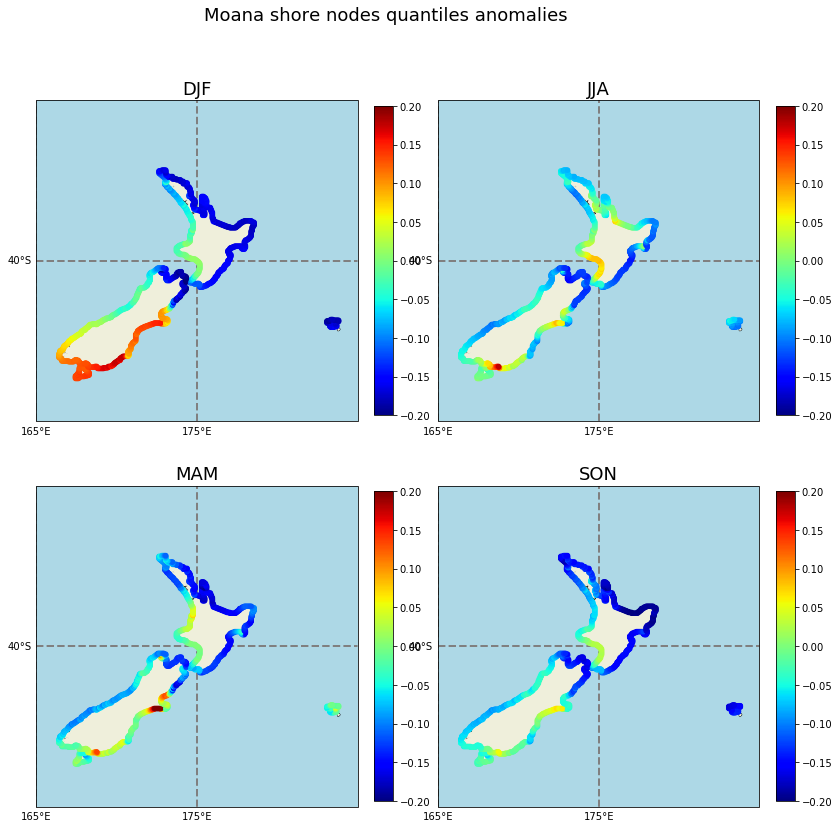

In [6]:
# load moana
moana = load_moana_hindcast(plot=True)
moana_closest_sites = []


 loading and plotting the GeoOcean tidal guages... 


 Loading and plotting the UHSLC tidal guages... 



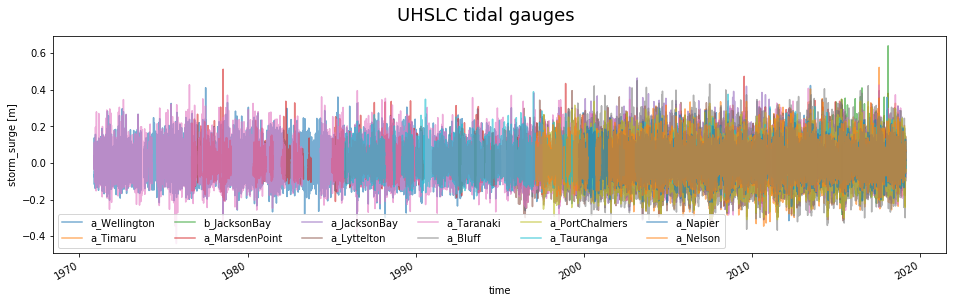

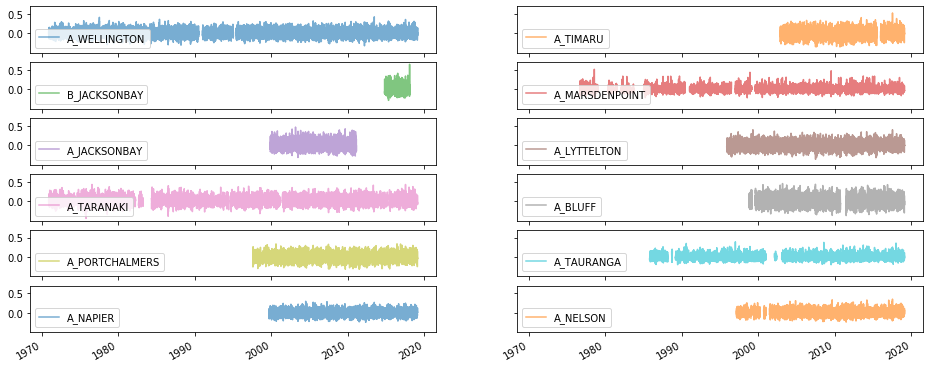

In [7]:
# load geotgs and uhslc
tgs = load_geocean_tgs(plot=False)
uhslctgs = join_load_uhslc_tgs(plot=True)

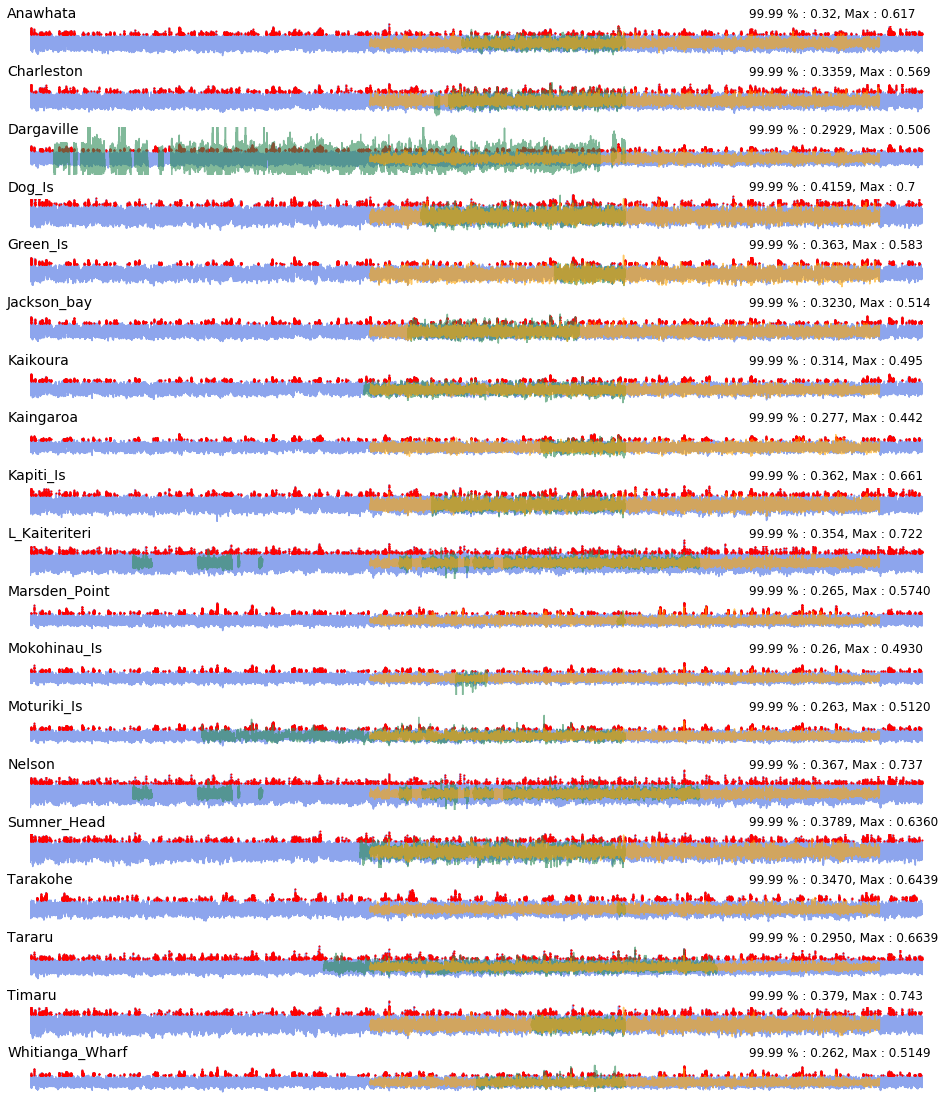

In [8]:
# plot time series
fig, axes = plt.subplots(nrows=19,figsize=(16,20),sharex=True)
fig.subplots_adjust(hspace=0.2)
for axi, ax in enumerate(axes):
    codec.isel(name=axi).ss.plot(ax=ax,c='royalblue',alpha=0.6)
    ax.plot(codec_max.isel(name=axi).time.values,
            codec_max.isel(name=axi).ss.values,
            '.', c='red', markersize=2)
    # ax.plot(tcs_time, codec.sel(time=tcs_time).ss.values, '.',
    #         c='darkred', markersize=1)
    tgs.isel(name=axi).ss.plot(ax=ax,c='seagreen',alpha=0.6)
    site = -1
    min_dist = 8888
    for isite in range(len(moana.site.values)):
        site_lon_pre = moana.isel(site=isite).lon.values
        site_lon = site_lon_pre if site_lon_pre<=180 else site_lon_pre-360
        site_lat = moana.isel(site=isite).lat.values
        dist = geodesic((site_lat,site_lon),
                        (tgs.isel(name=axi).latitude.values,
                         tgs.isel(name=axi).longitude.values)).km
        if dist<min_dist:
            site=isite
            min_dist=dist
    try:
        moana.isel(site=site).ss.plot(ax=ax,c='orange',alpha=0.6)
        moana_closest_sites.append(site)
    except:
        pass
    ax.text(datetime(1979,1,5),0.8,codec.name.values[axi],size=14,
            backgroundcolor='white')
    ax.text(datetime(2011,6,6),0.8,
            '99.99 % : {}, Max : {}'.format(
                str(codec.isel(name=axi).ss.quantile(0.995).values)[:6],
                str(codec.isel(name=axi).ss.max().values)[:6]),
            size=12,backgroundcolor='white')
    ax.set_title('')
    ax.set_ylim(-0.5,1.0)
    ax.set_xlim(codec.time.values[0],codec.time.values[-1])
    ax.axis('off')
    ax.set_facecolor('white')
fig.patch.set_facecolor('white')

In [9]:
# stations
moana_closest_sites

[1193,
 613,
 1323,
 117,
 212,
 393,
 578,
 460,
 787,
 744,
 1327,
 1319,
 1124,
 709,
 480,
 803,
 1174,
 325,
 1214]

In [10]:
# moana.isel(site=moana_closest_sites).to_netcdf('data/SS_NZ_NunMod_MOANA.nc')

In [11]:
# we extract the days we have storms
storm_days = pd.to_datetime(codec_max.ss.dropna(dim='time',how='all').time.values)\
    .round('3D').unique()
storm_days = storm_days[storm_days>dac.time.values[0]] # where dac exists

In [12]:
def extract_time_period(storm_day):
    '''
        Extract the tie lapse
    '''
    return (str(storm_day-timedelta(days=3)), str(storm_day+timedelta(days=2)))
    
# storm day widget selection
storm_day = widgets.Dropdown(options=storm_days,
                             value=storm_days[100],
                             description='Select storm DAY: ')
storm_period_selection = interactive(extract_time_period,
                                     storm_day = storm_day)
storm_period_selection

interactive(children=(Dropdown(description='Select storm DAY: ', index=100, options=(Timestamp('1993-01-12 00:…

In [13]:
storm_period_selection.result, storm_day.value

(('1995-01-29 00:00:00', '1995-02-03 00:00:00'),
 Timestamp('1995-02-01 00:00:00'))

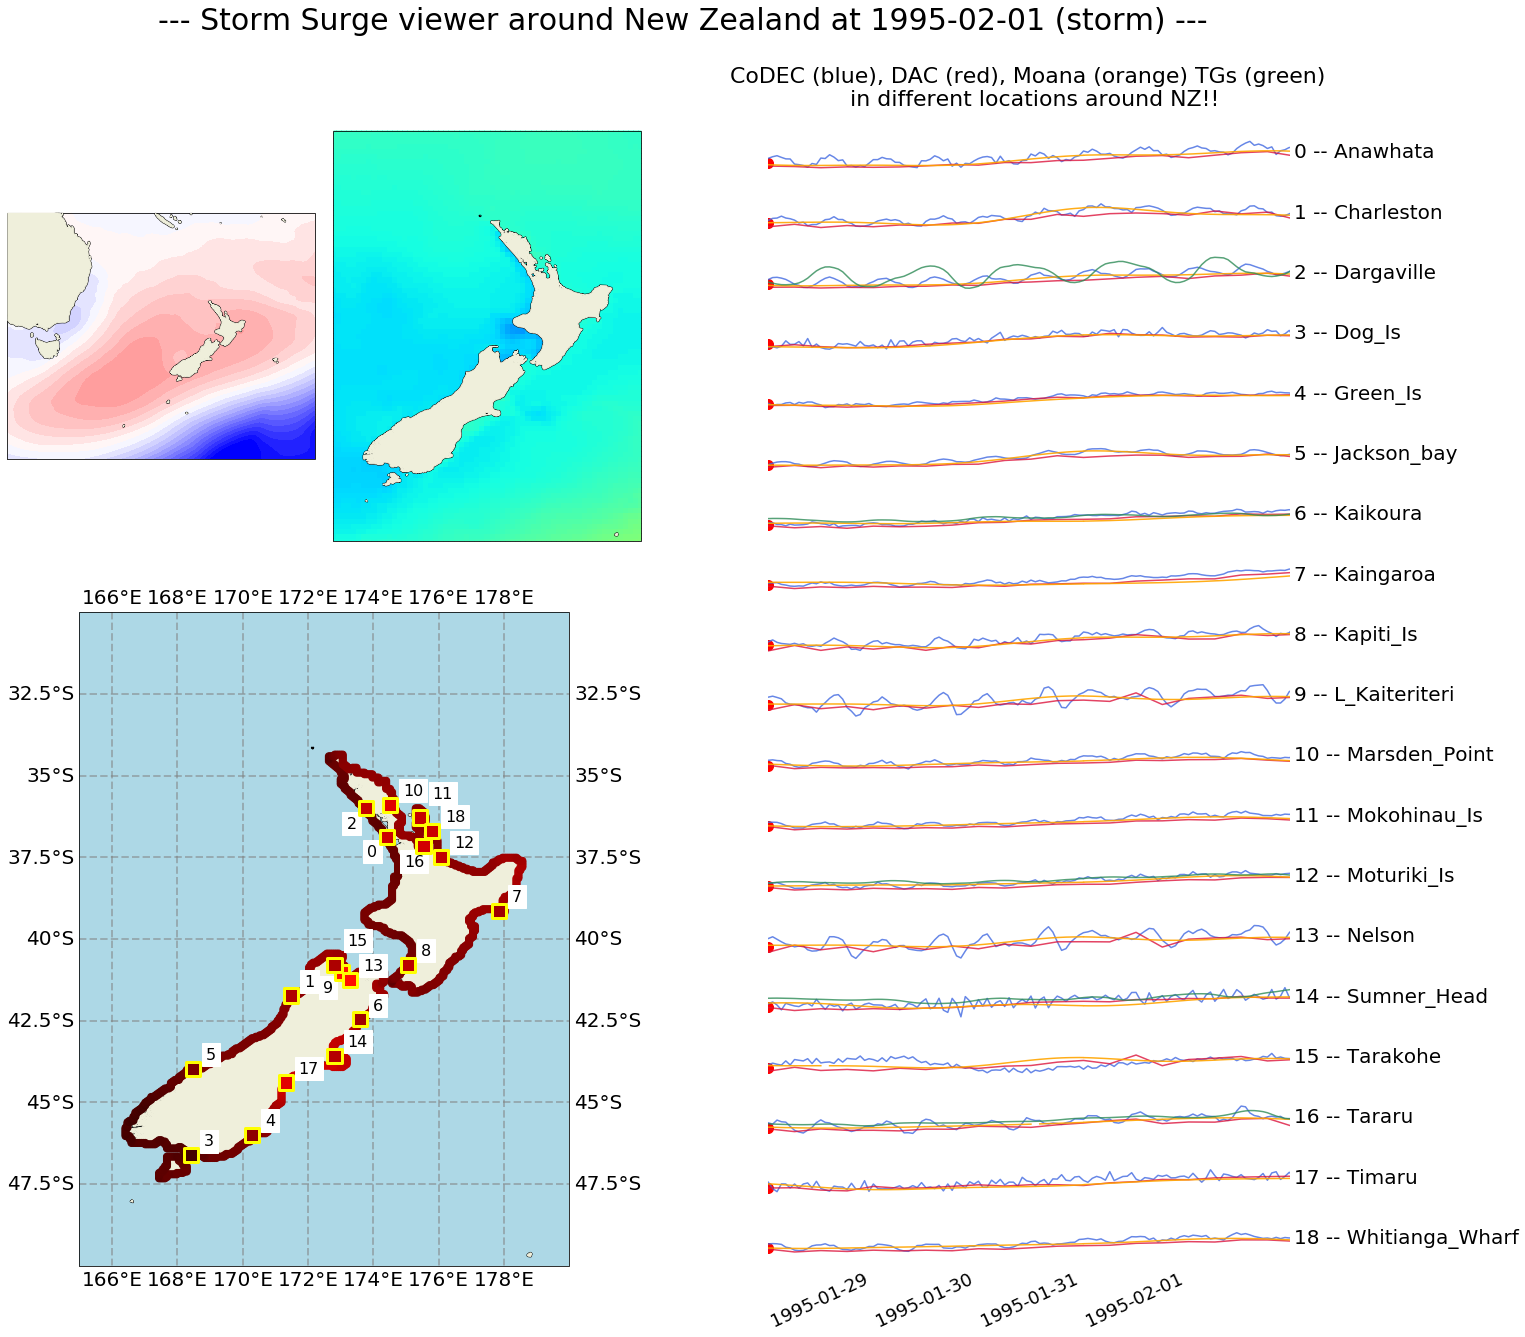

In [14]:
# ANIMATION !!

# grids, axes and fig
fig = plt.figure(figsize=(25,22))
gs = gridspec.GridSpec(nrows=20,ncols=13)
ax1 = fig.add_subplot(gs[:9,0:3],projection=ccrs.PlateCarree(central_longitude=165))
ax2 = fig.add_subplot(gs[:9,3:6],projection=ccrs.PlateCarree(central_longitude=165))
ax3 = fig.add_subplot(gs[9:,:6],projection=ccrs.PlateCarree(central_longitude=165))
axes = [fig.add_subplot(gs[i+1,7:12]) for i in range(19)]
ax1.set_extent([140,190,-20,-60],crs=ccrs.PlateCarree())
ax2.set_extent([165,180,-30,-50],crs=ccrs.PlateCarree())
ax3.set_extent([165,180,-30,-50],crs=ccrs.PlateCarree())
gl = ax3.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,
                   linewidth=2,color='gray',alpha=0.5,linestyle='--')
gl.xlabel_style = {'color':'black','size':20}
gl.ylabel_style = {'color':'black','size':20}
gl.top_labels = True
gl.left_labels = True
ax3.set_facecolor('lightblue')
fig.suptitle('--- Storm Surge viewer around New Zealand at ' \
             + str(storm_day.value)[:10] + ' (storm) ---',
             fontsize=30, y=0.92)

# initialize in range
slp_storm = slp.sel(time=slice(*storm_period_selection.result))
dac_storm = dac.sel(time=slice(*storm_period_selection.result))\
    .resample(time='1H').interpolate('nearest')
codec_storm = codec.sel(time=slice(*storm_period_selection.result))  
moana_storm = moana.sel(time=slice(*storm_period_selection.result))
tgs_storm = tgs.sel(time=slice(*storm_period_selection.result))

# points to animate
points = [ax.plot([],[],'.',c='red',markersize=20)[0] for ax in axes]

def plot_times(ax):
    for t in range(0,len(codec_storm.time.values)-25,24):
        ax.text(codec_storm.time.values[t],-3.2,
                str(codec_storm.time.values[t])[:10],
                size=18,rotation=25)

def plot_numbers(ax,sss):
    number = 0
    for lon,lat in zip(codec_storm.codec_coords_lon.values,
                       codec_storm.codec_coords_lat.values):
        if number==9 or number==2 or number==0 or number==16:
            ax.text(lon-0.6,lat-0.6,number,size=16,zorder=15,
                    backgroundcolor='white' if sss[number]<0.3 else 'red',
                    transform=ccrs.PlateCarree())
        elif number==11 or number==15:
            ax.text(lon+0.4,lat+0.6,number,size=16,zorder=15,
                    backgroundcolor='white' if sss[number]<0.3 else 'red',
                    transform=ccrs.PlateCarree())
        else:
            ax.text(lon+0.4,lat+0.3,number,size=16,zorder=15,
                    backgroundcolor='white' if sss[number]<0.3 else 'red',
                    transform=ccrs.PlateCarree())
        number += 1

# initialization function: plot the background of each frame
def init():
    slpcol = slp_storm.isel(time=0).plot.contourf(
        transform=ccrs.PlateCarree(),ax=ax1,
        cmap='bwr',levels=30,add_colorbar=False,
        vmin=101300-3000,vmax=101300+3000)
    daccol = dac_storm.isel(time=0).plot(
        transform=ccrs.PlateCarree(),ax=ax2,
        cmap='jet',vmin=-0.5,vmax=0.6,
        add_colorbar=False)
    codeccol = ax3.scatter(
        codec_storm.codec_coords_lon.values, 
        codec_storm.codec_coords_lat.values,
        s=200,c=codec_storm.isel(time=0).ss.values, 
        cmap='hot',zorder=16,label='CoDEC nodes',
        vmin=-0.2,vmax=0.6,marker='s',
        edgecolor='yellow',linewidth=3,
        transform=ccrs.PlateCarree())
    moanacol = ax3.scatter(moana_storm.lon.values,
                           moana_storm.lat.values,
                           s=50,c=moana_storm.isel(time=0).ss.values,
                           cmap='hot',zorder=14,label='Moana Dataset',
                           vmin=-0.2,vmax=0.6,transform=ccrs.PlateCarree())
    # try:
    #     ax3.scatter(tgs_storm.longitude.values, 
    #                 tgs_storm.latitude.values,
    #                 s=120,c=tgs_storm.isel(time=0).ss.values, 
    #                 cmap='hot',zorder=17,label='Real TGs',
    #                 vmin=-0.2,vmax=0.6,edgecolor='blue',
    #                 transform=ccrs.PlateCarree())
    # except:
    #     pass
    # set legend and numbers
    # ax3.legend(fontsize=16)
    plot_numbers(ax3,codec_storm.isel(time=0).ss.values)
    # plot codec/tgs time series
    for axi, ax in enumerate(axes):
        ax.plot(codec_storm.isel(name=axi).time.values,
                codec_storm.isel(name=axi).ss.values*2,
                c='royalblue',alpha=0.8,label='CoDEC')
        ilon = np.argmin(np.abs(dac_storm.longitude.values - \
            codec_storm.isel(name=axi).codec_coords_lon.values))
        ilat = np.argmin(np.abs(dac_storm.latitude.values - \
            codec_storm.isel(name=axi).codec_coords_lat.values))
        ax.plot(dac.isel(longitude=ilon,latitude=ilat).time.values,
                dac.isel(longitude=ilon,latitude=ilat).values*2,
                c='crimson',alpha=0.8,label='DAC')
        ax.plot(moana_storm.isel(site=moana_closest_sites[axi]).time.values,
                moana_storm.isel(site=moana_closest_sites[axi]).ss.values*2,
                c='orange',alpha=0.9,label='Moana Dataset')
        try:
            ax.plot(tgs_storm.isel(name=axi).time.values,
                    tgs_storm.isel(name=axi).ss.values*2,
                    c='seagreen',alpha=0.8,label='TGs')
        except:
            pass
        ax.text(codec_storm.time.values[-1],0.1,
                str(axi)+' -- '+str(codec_storm.name.values[axi]),
                size=20,backgroundcolor='white')
        if axi==0:
            ax.set_title('CoDEC (blue), DAC (red), Moana (orange) TGs (green) \n '+
                         'in different locations around NZ!!',
                         fontsize=22,loc='center',y=1.1,pad=25)
            # ax.legend(loc='center',fontsize=16,ncol=4)
        else:
            ax.set_title('')
        ax.set_ylim(-0.8,1.2)
        ax.set_xlim(codec_storm.time.values[0],codec_storm.time.values[-1])
        if axi==len(axes)-1:
            plot_times(ax)
        ax.axis('off')
        points[axi].set_data(moana_storm.time.values[0],
                             moana_storm.isel(site=axi,time=0).ss.values*2)
    for ax, cbar in zip([ax1,ax2,ax3],[slpcol,daccol,codeccol]):
        ax.coastlines(linewidth=2)
        ax.add_feature(fcart.LAND,zorder=10)
        ax.set_title('')
    
    return points  
    
# animation function.  This is called sequentially
def animate(step):
    slp_storm.isel(time=step).plot.contourf(
        transform=ccrs.PlateCarree(),ax=ax1,
        cmap='bwr',levels=30,add_colorbar=False,
        vmin=101300-3000,vmax=101300+3000)
    dac_storm.isel(time=step).plot(
        transform=ccrs.PlateCarree(),ax=ax2,
        cmap='jet',vmin=-0.5,vmax=0.6, 
        add_colorbar=False)
    ax3.scatter(codec_storm.codec_coords_lon.values, 
                codec_storm.codec_coords_lat.values,
                s=200,c=codec_storm.isel(time=step).ss.values, 
                cmap='hot',zorder=16,label='CoDEC nodes',
                vmin=-0.2,vmax=0.6,marker='s',
                edgecolor='yellow',linewidth=3,
                transform=ccrs.PlateCarree())
    ax3.scatter(moana_storm.lon.values,
                moana_storm.lat.values,
                s=50,c=moana_storm.isel(time=step).ss.values,
                cmap='hot',zorder=14,label='Moana Dataset',
                vmin=-0.2,vmax=0.6,transform=ccrs.PlateCarree())
    plot_numbers(ax3,codec_storm.isel(time=step).ss.values)
    for ax in [ax1,ax2,ax3]:
        ax.set_title('')
    ax2.set_title('Current time: '+str(slp_storm.time.values[step])[:16],
                  loc='center',fontsize=25,y=1.1,x=0.1,pad=25)
    for axi, ax in enumerate(axes):
        points[axi].set_data(moana_storm.time.values[step],
                             moana_storm.isel(site=axi,time=step).ss.values*2)
    
    return points

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=10, interval=2000, blit=True,
                               repeat_delay=5000)

In [15]:
from IPython.display import HTML
matplotlib.rcParams['animation.embed_limit'] = 2**32
HTML(anim.to_jshtml())